# Deep neural net classification of short text using pre-trained language model

Written for python 3.7, meant to run with 4GB CUDA-capable machine (iceberg)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import fastprogress
bs = 32 # size of minibatch
# written with fastai v1.0.48

from collections import defaultdict

In [3]:
lang_model_path = Path('/data/fastai-models/language_model')
vocab = Vocab(pickle.load(open(lang_model_path/'itos.pkl','rb')))

In [4]:
# load our labeled data into a TextClasDataBunch
model_path = Path('/data/fastai-models')
path = Path('../labeled_data')
fold = 1
fold_name = 'fold_' + str(fold)
model_path /= fold_name
path /= fold_name
groupname = 'label_usforeign' #'label_category'
train_df = pd.read_csv(path/groupname/(groupname+'_train.tsv'), header=None, delimiter='\t', names=['label','text'])
valid_df = pd.read_csv(path/groupname/(groupname+'_valid.tsv'), header=None, delimiter='\t', names=['label','text'])

data_clas = TextClasDataBunch.from_df(model_path, train_df, valid_df, vocab=vocab, text_cols='text', label_cols='label', bs=bs)
# label_delim=',' # for multilabel
#data_clas.save('fold_'+fold+'-'+groupname+'_clas')

In [5]:
sys.path.append("..") # Adds higher directory to python modules path.
if groupname == 'multilabel':
    from common import Label_DbFields, Labels
    class_mask = [c in Labels['label_category'] for c in data_clas.train_ds.classes]
    class_idxes = sorted([data_clas.train_ds.classes.index(c) for c in Labels['label_category']])

In [7]:
torch.cuda.is_available()

True

In [5]:
def accuracy_category(y_pred:Tensor, y_true:Tensor, class_idxes:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Gives accuracy when `y_pred` above threshold, only for the true column(s) among the `class_idxes` columns."
    # note this gives no penalty for marking other labels incorrectly among class_idxes columns
    # this is roughly comparable to accuracy for a single classifier with class_idxes' labels as the classes
    if sigmoid: y_pred = y_pred.sigmoid()
    correct_category_mask = y_true.index_select(1, class_idxes) > 0
    return (y_pred.index_select(1, class_idxes)[correct_category_mask] > thresh).float().mean()

In [12]:
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
top3accuracy = partial(top_k_accuracy, k=3)
top5accuracy = partial(top_k_accuracy, k=5)
#label_category_accuracy = partial(accuracy_category, class_idxes=tensor(class_idxes).cuda(), thresh=0.5)
if groupname in ('label_category', 'station'):
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.75, metrics=[accuracy, top3accuracy, top5accuracy])
elif groupname == 'multilabel':
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=1.0, metrics=[accuracy_thresh, label_category_accuracy, fbeta])
else:
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.75, metrics=[accuracy])
learn.load_encoder('../..'/lang_model_path/'lm_fine_tuned3_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


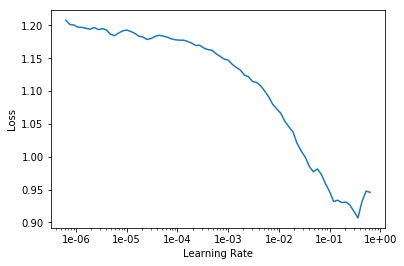

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [15]:
learn.fit_one_cycle(1, 2e-2, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.524364,0.483436,0.801619,00:07


In [16]:
learn.save('tone_pass_1')

In [9]:
float(learn.recorder.metrics[-1][0]) # last epoch, first metric

0.9099942445755005

In [18]:
learn.load('tone_pass_1')
#learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-2/(2.6**4),2e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,0.575747,0.502688,0.838057,00:08


In [19]:
learn.save('tone_pass_2')

In [20]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,0.432266,0.469823,0.825911,00:08


In [81]:
learn.save('tone_pass_2')

In [21]:
learn.load('tone_pass_2')
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3))#, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,0.463357,0.482475,0.834008,00:12


In [61]:
data_clas = None
gc.collect()

702

In [23]:
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3))#, moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,0.427636,0.458090,0.842105,00:12


In [24]:
learn.save('tone_pass_3b')

In [55]:
learn.load('tone_pass_3b')
learn.unfreeze()
learn.fit_one_cycle(1, slice(4e-3/(2.6**4),2e-3), moms=(0.9,0.8))
#learn.save(groupname+'_clas_fine_tuned')

epoch,train_loss,valid_loss,accuracy,time
0,0.409362,0.442650,0.842105,00:17


In [60]:
learn.fit_one_cycle(1, slice(3e-3/(2.6**4),1e-3), moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.355596,0.447332,0.825911,00:16


In [58]:
learn.export(groupname+'_clas_fine_tuned-fold1_.850-3.pkl')

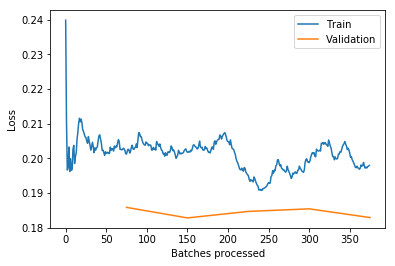

In [10]:
learn.recorder.plot_losses()

Here is how to run on test data / data without labels

In [ ]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [28]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('../..'/lang_model_path/'lm_fine_tuned3_enc')
learn.freeze()
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.85,0.75))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.85,0.75))
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.267345,0.120367,0.960133
2,0.145206,0.124274,0.953488


epoch,train_loss,valid_loss,accuracy
1,0.133902,0.176657,0.943522


epoch,train_loss,valid_loss,accuracy
1,0.099062,0.131643,0.953488


epoch,train_loss,valid_loss,accuracy
1,0.075871,0.135669,0.953488
2,0.045997,0.135994,0.953488


In [29]:
float(learn.recorder.metrics[-1][0])

0.9534883499145508

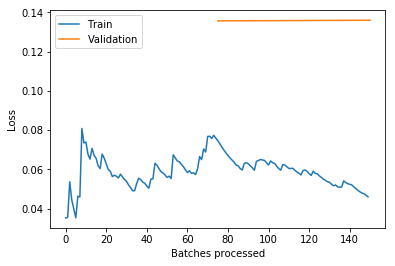

In [30]:
# this is apparently only plotting the most recent call to fit
learn.recorder.plot_losses()

In [4]:
# load our labeled data into a TextClasDataBunch
model_path = Path('/home/briggsjt/fastai_models')
path = Path('../labeled_data')

In [10]:
# dir structure: labeled_data/fold_i/groupname/groupname_[train|valid].tsv for i in 0..4
fold_accuracies = defaultdict(list)
for fold in range(5):
    fold_name = 'fold_' + str(fold)
    for groupfilepath in (path/fold_name).ls():
        groupname = str(groupfilepath.parts[-1])
        print('Processing ' + fold_name + ' ' + groupname + '\n\n')
        
        # load the training and validation data for this group name and fold
        train_df = pd.read_csv(path/fold_name/groupname/(groupname+'_train.tsv'), header=None, delimiter='\t', names=['label','text'])
        valid_df = pd.read_csv(path/fold_name/groupname/(groupname+'_valid.tsv'), header=None, delimiter='\t', names=['label','text'])

        # settings for single vs multi-label learners
        metrics = [accuracy]
        label_delim = None
        initial_lr = 1e-2
        if groupname == 'multilabel':
            metrics = [accuracy_thresh] # accuracy per label at default threshold of 0.5
            label_delim = ','
            initial_lr *= 4
        
        data_clas = TextClasDataBunch.from_df(model_path/fold_name, train_df, valid_df, vocab=vocab, 
                                              text_cols='text', label_cols='label', bs=bs,
                                              label_delim=label_delim)
        #data_clas.save('fold_'+fold+'-'+groupname+'_clas')
        
        learn = text_classifier_learner(data_clas, metrics=metrics, drop_mult=0.6)
        learn.load_encoder('../..'/lang_model_path/'lm_fine_tuned3_enc')
        learn.freeze()
        learn.fit_one_cycle(2, initial_lr, moms=(0.8,0.7))
        learn.freeze_to(-2)
        learn.fit_one_cycle(1, slice(initial_lr/(2.6**4), initial_lr), moms=(0.85,0.75))
        learn.freeze_to(-3)
        learn.fit_one_cycle(1, slice(initial_lr*0.5/(2.6**4), initial_lr*0.5), moms=(0.85,0.75))
        learn.unfreeze()
        learn.fit_one_cycle(2, slice(initial_lr*0.1/(2.6**4), initial_lr*0.1), moms=(0.8,0.7))
        learn.save(groupname+'_clas_fine_tuned')
        
        # save accuracies for later use
        fold_accuracies[groupname].append(float(learn.recorder.metrics[-1][0]))

epoch,train_loss,valid_loss,accuracy
1,0.903922,0.733835,0.693333
2,0.700443,0.667015,0.736667


epoch,train_loss,valid_loss,accuracy
1,0.684584,0.697587,0.730000


epoch,train_loss,valid_loss,accuracy
1,0.591699,0.640709,0.783333


epoch,train_loss,valid_loss,accuracy
1,0.430048,0.636889,0.773333
2,0.425984,0.653159,0.753333


In [12]:
print("Cross-fold cross-validation statistics:")
for labelgroup, accuracies in fold_accuracies.items():
    accuracies = np.array(accuracies)
    print("For %s, mean %02f, SD %02f" % (labelgroup, 100.*accuracies.mean(), 100.*accuracies.std()))

Cross-fold cross-validation statistics:
For hardsoft, mean 81.838095, SD 1.962533
For factinvestigative, mean 64.955554, SD 0.775821
For label_emotion, mean 79.018009, SD 2.642516
For label_usforeign, mean 81.457543, SD 3.703197
For label_investigative, mean 80.587078, SD 7.277574
For label_category, mean 68.002437, SD 3.406711
For nonsense, mean 97.538649, SD 0.930303
For label_tone, mean 55.987773, SD 2.108498
For multilabel, mean 92.234118, SD 0.371366
For ads, mean 95.808859, SD 1.875260
For transitions, mean 94.610852, SD 1.492980
For label_factopinion, mean 70.605471, SD 1.268338
For supergroups, mean 77.179623, SD 1.984949


In [23]:
# disable progress bars, see https://forums.fast.ai/t/default-to-completely-disable-progress-bar/40010
import fastai, fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = fastprogress.force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar
fastai.basic_data.master_bar, fastai.basic_data.progress_bar = master_bar, progress_bar
#dataclass.master_bar, dataclass.progress_bar = master_bar, progress_bar
fastai.text.master_bar, fastai.text.progress_bar = master_bar, progress_bar
fastai.text.data.master_bar, fastai.text.data.progress_bar = master_bar, progress_bar
fastai.core.master_bar, fastai.core.progress_bar = master_bar, progress_bar

In [16]:
sys.path.append("..") # Adds higher directory to python modules path.
from common import Label_DbFields, Labels
class_mask = [c in Labels['label_category'] for c in data_clas.train_ds.classes]
class_idxes = sorted([data_clas.train_ds.classes.index(c) for c in Labels['label_category']])